<a href="https://colab.research.google.com/github/alby1976/Data607608Project/blob/master/notebook/DATA607_GroupProject_al.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning Question 1
**Is there any pattern of solved or unsolved cases based on the type of victim, weapon, circumstance and geography region where crimes were occurred?**

Based on Yu's work, we wanted to see if creating a sequential neural network model would improve prediction accuracy. There was overfitting in our initial model and dropouts and regularizers were introduced. The final model gave us a training accuracy of 0.9812 and a testing accuracy of 0.9965.

## Setup

In [ ]:
!pip install nbconvert
!apt-get update
!apt-get install pandoc 
!add-apt-repository universe
!add-apt-repository ppa:inkscape.dev/stable
!apt-get update
!apt install inkscape
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [ ]:
!pip install scikit-learn --upgrade
!pip install keras --upgrade
!pip install tensorflow --upgrade



In [3]:

#mount Google drive
from google.colab import drive
from os.path import join
ROOT = '/content/drive' # default for the drive
print(ROOT)
drive.mount(ROOT) # we mount the drive at /content/drive

/content/drive
Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

filedir = '/content/drive/MyDrive/Project 607!608'
if filedir.endswith('/') != True:
  filedir += '/'
  
def convert (df, colname, lookup):
  df.loc[df[colname] == lookup[0], colname] = lookup[1]
  return df

def convert_list (df, colname, lookups):
  for lookup in lookups:
    df = convert(df, colname, lookup)
  return df

# Conversion array
agegroup = zip([x for x in range (0, 19)], ['Total', 
  'Age 0 to 4 years', 
  'Age 5 to 9 years', 
  'Age 10 to 14 years',
  'Age 15 to 19 years', 
  'Age 20 to 24 years', 
  'Age 25 to 29 years', 
  'Age 30 to 34 years', 
  'Age 35 to 39 years', 
  'Age 40 to 44 years', 
  'Age 45 to 49 years', 
  'Age 50 to 54 years', 
  'Age 55 to 59 years', 
  'Age 60 to 64 years', 
  'Age 65 to 69 years', 
  'Age 70 to 74 years', 
  'Age 75 to 79 years', 
  'Age 80 to 84 years', 
  'Age 85 years or older'])

def calculate_agegroup(age):
  if age == 999:
    return 0
  elif age >= 85:
    return 18
  else:
    return (age // 5) + 1

# conversion array
solved = zip(['Yes', 'No'],[True, False])
month = zip(['January', 'February', 'March', 'April', 'May','June', 'July', 'August', 'September','October', 'November', 'December'], [x for x in range(1,13)])

#column data type

category = ['ID', 'CNTYFIPS', 'Ori', 'State', 'Agency', 'Agentype',
       'Source', 'Solved', 'ActionType',
       'Homicide', 'Situation', 'VicSex', 'VicRace', 'VicEthnic',
       'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicAgeGroup', 'OffAgeGroup']
murder = pd.read_csv(filedir + 'SHR76_19.csv')
murder.to_parquet('SHR76_19.parquet', index=False)
murder = pd.read_parquet('SHR76_19.parquet')
loc = murder[['State','CNTYFIPS']]
ages = murder.VicAge
murder['VicAgeGroup'] = [calculate_agegroup(age) for age in ages] 
ages = murder.OffAge
murder['OffAgeGroup'] = [calculate_agegroup(age) for age in ages]
murder.VicCount += 1
murder.OffCount += 1
#murder = convert_list(murder,'Solved', solved)
murder = convert_list(murder,'Month', month)
murder.Month = murder.Month.apply(pd.to_numeric)
#murder.FileDate = pd.to_datetime(murder.FileDate, format='%m%d%y')
murder.loc[:,category] = murder.loc[:,category].astype('category')


## Neural Network - Victim's demographics


In [ ]:
import numpy as np

from sklearn.compose import ColumnTransformer
#from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers

df_victim = murder[['CNTYFIPS', 'State', 'Solved','Year', 'Incident', 'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount']]
df_victim = df_victim.dropna()

solvedBinarizer = LabelBinarizer().fit(df_victim.Solved)
X = df_victim.drop(columns=['Solved'])
y = solvedBinarizer.transform(df_victim.Solved)
df_victim.drop(columns=['Solved'], inplace=True)

# create a function that returns a model, taking as parameters things you
# want to verify using cross-valdiation and model selection
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform',
                 dropout=0.2,
                 weight_penalities=0.01):
    model = Sequential()
    model.add(Dense(4,activation='relu',kernel_initializer=kernel_initializer, bias_regularizer=regularizers.l1(weight_penalities)))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='sigmoid',kernel_initializer=kernel_initializer))

    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    return model

# wrap the model using the function you created
clf_victim = KerasClassifier(build_fn=create_model,epochs=10, batch_size=32, verbose=2)


seed = 42
cat_victim = np.array(df_victim.select_dtypes(include=['category']).columns)
num_victim= np.array(df_victim.select_dtypes(exclude=['category']).columns)
display(cat_victim,num_victim)

numeric_features = num_victim
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

categorical_features = cat_victim
categorical_transformer = OneHotEncoder(handle_unknown='ignore', )

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

pipeline_victim = Pipeline(steps=[('classifier', clf_victim)])

X_train, X_test, y_train, y_test = train_test_split(preprocessor.fit_transform(X), y, test_size=0.2,
                                                    random_state=seed)
pipeline_victim.fit(X_train, y_train, classifier__validation_data=(X_test, y_test))

#%%
# Evaluation
#y_pred = (pipeline.predict(X_test) > 0.5).astype("int32")
y_pred = pipeline_victim.predict(X_test)
print()
print(np.mean((y_test) == y_pred))




array(['CNTYFIPS', 'State', 'Homicide', 'Situation', 'VicSex', 'VicRace',
       'VicEthnic', 'Weapon', 'Relationship', 'Circumstance', 'Subcircum'],
      dtype=object)

array(['Year', 'Incident', 'VicAge', 'VicCount', 'OffCount'], dtype=object)

Epoch 1/10
788/788 - 2s - loss: 0.2738 - accuracy: 0.9157 - val_loss: 0.1393 - val_accuracy: 0.9143
Epoch 2/10
788/788 - 2s - loss: 0.1156 - accuracy: 0.9475 - val_loss: 0.0389 - val_accuracy: 0.9940
Epoch 3/10
788/788 - 2s - loss: 0.0595 - accuracy: 0.9796 - val_loss: 0.0240 - val_accuracy: 0.9962
Epoch 4/10
788/788 - 2s - loss: 0.0509 - accuracy: 0.9813 - val_loss: 0.0216 - val_accuracy: 0.9963
Epoch 5/10
788/788 - 2s - loss: 0.0474 - accuracy: 0.9825 - val_loss: 0.0202 - val_accuracy: 0.9963
Epoch 6/10
788/788 - 2s - loss: 0.0480 - accuracy: 0.9807 - val_loss: 0.0199 - val_accuracy: 0.9965
Epoch 7/10
788/788 - 2s - loss: 0.0466 - accuracy: 0.9808 - val_loss: 0.0196 - val_accuracy: 0.9963
Epoch 8/10
788/788 - 2s - loss: 0.0455 - accuracy: 0.9812 - val_loss: 0.0191 - val_accuracy: 0.9963
Epoch 9/10
788/788 - 2s - loss: 0.0437 - accuracy: 0.9821 - val_loss: 0.0189 - val_accuracy: 0.9965
Epoch 10/10
788/788 - 2s - loss: 0.0444 - accuracy: 0.9812 - val_loss: 0.0189 - val_accuracy: 0.9965

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


197/197 - 0s

0.9965084907157594


### Keras Model

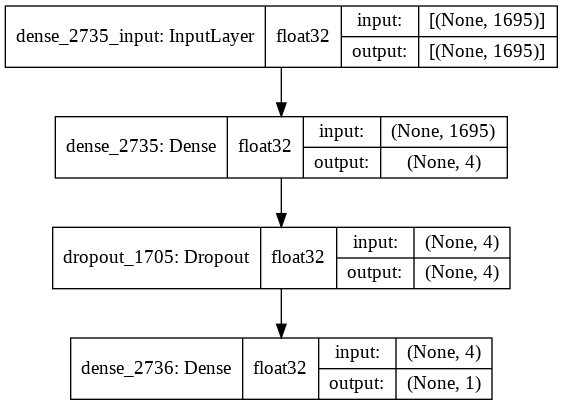

In [ ]:
#import Graphviz
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file=filedir + 'after-model.png')
plot_model(clf_victim.model, show_shapes=True, show_dtype=True, show_layer_names=True)


### Hyperparameter Tuning with Grid Search

To see whether tuning the hyperparameters would improve our testing accuracy, we used scikit learn's GridSearchCV module to tune the parameters. Employing this technique did improve our testing accuracy but the training accuracy was greater than the testing accuracy. Hence this model was dropped.

In [ ]:
# create parameter grid, as usual, but note that you can
# vary other model parameters such as 'epochs' (and others 
# such as 'batch_size' too)

param_grid = {
    'classifier__optimizer':['adam'],
    'classifier__epochs': [8, 10],
    'classifier__dropout': [0.3, 0.4, 0.5],
    'classifier__weight_penalities' :[0.01, 0.05, 0.1],
    'classifier__kernel_initializer':['glorot_uniform']}
print('\n',pipeline_victim.get_params(),'\n')
# if you're not using a GPU, you can set n_jobs to something other than 1
grid_victim = GridSearchCV(pipeline_victim, cv=5, param_grid=param_grid, verbose=2, return_train_score=True, refit=True)
grid_victim.fit(X_train, y_train, classifier__validation_data = (X_test, y_test))



 {'memory': None, 'steps': [('classifier', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0742dbde50>)], 'verbose': False, 'classifier': <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0742dbde50>, 'classifier__epochs': 10, 'classifier__batch_size': 32, 'classifier__verbose': 2, 'classifier__build_fn': <function create_model at 0x7f0742f92320>} 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Epoch 1/8
630/630 - 2s - loss: 0.1924 - accuracy: 0.9161 - val_loss: 0.0939 - val_accuracy: 0.9143
Epoch 2/8
630/630 - 1s - loss: 0.0949 - accuracy: 0.9524 - val_loss: 0.0700 - val_accuracy: 0.9911
Epoch 3/8
630/630 - 1s - loss: 0.0753 - accuracy: 0.9870 - val_loss: 0.0596 - val_accuracy: 0.9935
Epoch 4/8
630/630 - 1s - loss: 0.0638 - accuracy: 0.9888 - val_loss: 0.0513 - val_accuracy: 0.9960
Epoch 5/8
630/630 - 1s - loss: 0.0574 - accuracy: 0.9899 - val_loss: 0.0459 - val_accuracy: 0.9963
Epoch 6/8
630/630 - 1s - loss: 0.05

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0742dbde50>)]),
             param_grid={'classifier__dropout': [0.3, 0.4, 0.5],
                         'classifier__epochs': [8, 10],
                         'classifier__kernel_initializer': ['glorot_uniform'],
                         'classifier__optimizer': ['adam'],
                         'classifier__weight_penalities': [0.01, 0.05, 0.1]},
             return_train_score=True, verbose=2)

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_victim.best_score_, grid_victim.best_params_))
means = grid_victim.cv_results_['mean_test_score']
stds = grid_victim.cv_results_['std_test_score']
params = grid_victim.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
#print("model score: %.3f" % clf.score(X_test, y_test))

print(f"model training accuracy:{grid_victim.score(X_train, y_train):.3f} testing accuracy:{grid_victim.score(X_test, y_test):.3f}")


Best: 0.997778 using {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam', 'classifier__weight_penalities': 0.01}
0.997381 (0.000882) with: {'classifier__dropout': 0.3, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam', 'classifier__weight_penalities': 0.01}
0.982027 (0.030298) with: {'classifier__dropout': 0.3, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam', 'classifier__weight_penalities': 0.05}
0.997738 (0.000829) with: {'classifier__dropout': 0.3, 'classifier__epochs': 8, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam', 'classifier__weight_penalities': 0.1}
0.997778 (0.000788) with: {'classifier__dropout': 0.3, 'classifier__epochs': 10, 'classifier__kernel_initializer': 'glorot_uniform', 'classifier__optimizer': 'adam', 'classifier__weight_pen